In [ ]:
#%%

# MA Cross Backtesting on 1H BTC on lower granularity
# - Taker fee               is 0.05%
# - Initial capital         is 10000.0$
# - Timeframe               is 1H
# 

In [ ]:
#%%

import warnings
warnings.filterwarnings("ignore")
def action_with_warnings():
    warnings.warn("should not appear")
with warnings.catch_warnings(record=True):
    action_with_warnings()
import yfinance          as yf
import pandas            as pd
import numpy             as np
import quantstats        as qs
import matplotlib.pyplot as plt

In [ ]:
#%%

df_ = pd.read_csv("./data/BTCUSDT/BTCUSDT.csv", parse_dates=True, index_col=0)
df_.index = pd.to_datetime(df_.index, format='mixed')
df_.index = pd.DatetimeIndex(df_.index)
df_

,Open,High,Low,Close,Volume
date,,,,,
2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,1.775183
2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000
2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074
2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008
2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796
...,...,...,...,...,...
2023-12-31 23:55:00,42222.11,42236.23,42222.10,42230.47,16.219540
2023-12-31 23:56:00,42230.47,42240.93,42222.10,42240.93,8.280760
2023-12-31 23:57:00,42240.92,42276.65,42240.92,42276.65,9.587640


In [ ]:
#%%

hours               = 1
timeframe_by_minute = hours*60
timeframe = f"{timeframe_by_minute}Min"

df = df_.resample(timeframe).agg({'Open':'first', 'High':'max', 'Low':'min', 'Close':'last', 'Volume': 'sum'})
df.dropna(inplace=True) # Dropping because of FX doesn't trade during weekends

df

,Open,High,Low,Close,Volume
date,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916
2017-08-17 06:00:00,4315.32,4345.45,4309.37,4324.35,7.229691
2017-08-17 07:00:00,4324.35,4349.99,4287.41,4349.99,4.443249
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807
...,...,...,...,...,...
2023-12-31 19:00:00,42656.69,42695.44,42586.91,42619.04,703.557910
2023-12-31 20:00:00,42619.04,42680.36,42504.56,42558.01,1015.140350
2023-12-31 21:00:00,42558.02,42670.44,42520.72,42520.72,923.438130


In [ ]:
#%%

# Signal extraction

df['MAFAST' ] = df['Close'].rolling(window= 70).mean()
df['MASLOW'] = df['Close'].rolling(window=250).mean()

df['Signal'] = 0
df.loc[((df['MAFAST'] > df['MASLOW']) & (df['MAFAST'].shift(1) <= df['MASLOW'].shift(1))), 'Signal'] =  1
df.loc[((df['MAFAST'] < df['MASLOW']) & (df['MAFAST'].shift(1) >= df['MASLOW'].shift(1))), 'Signal'] = -1

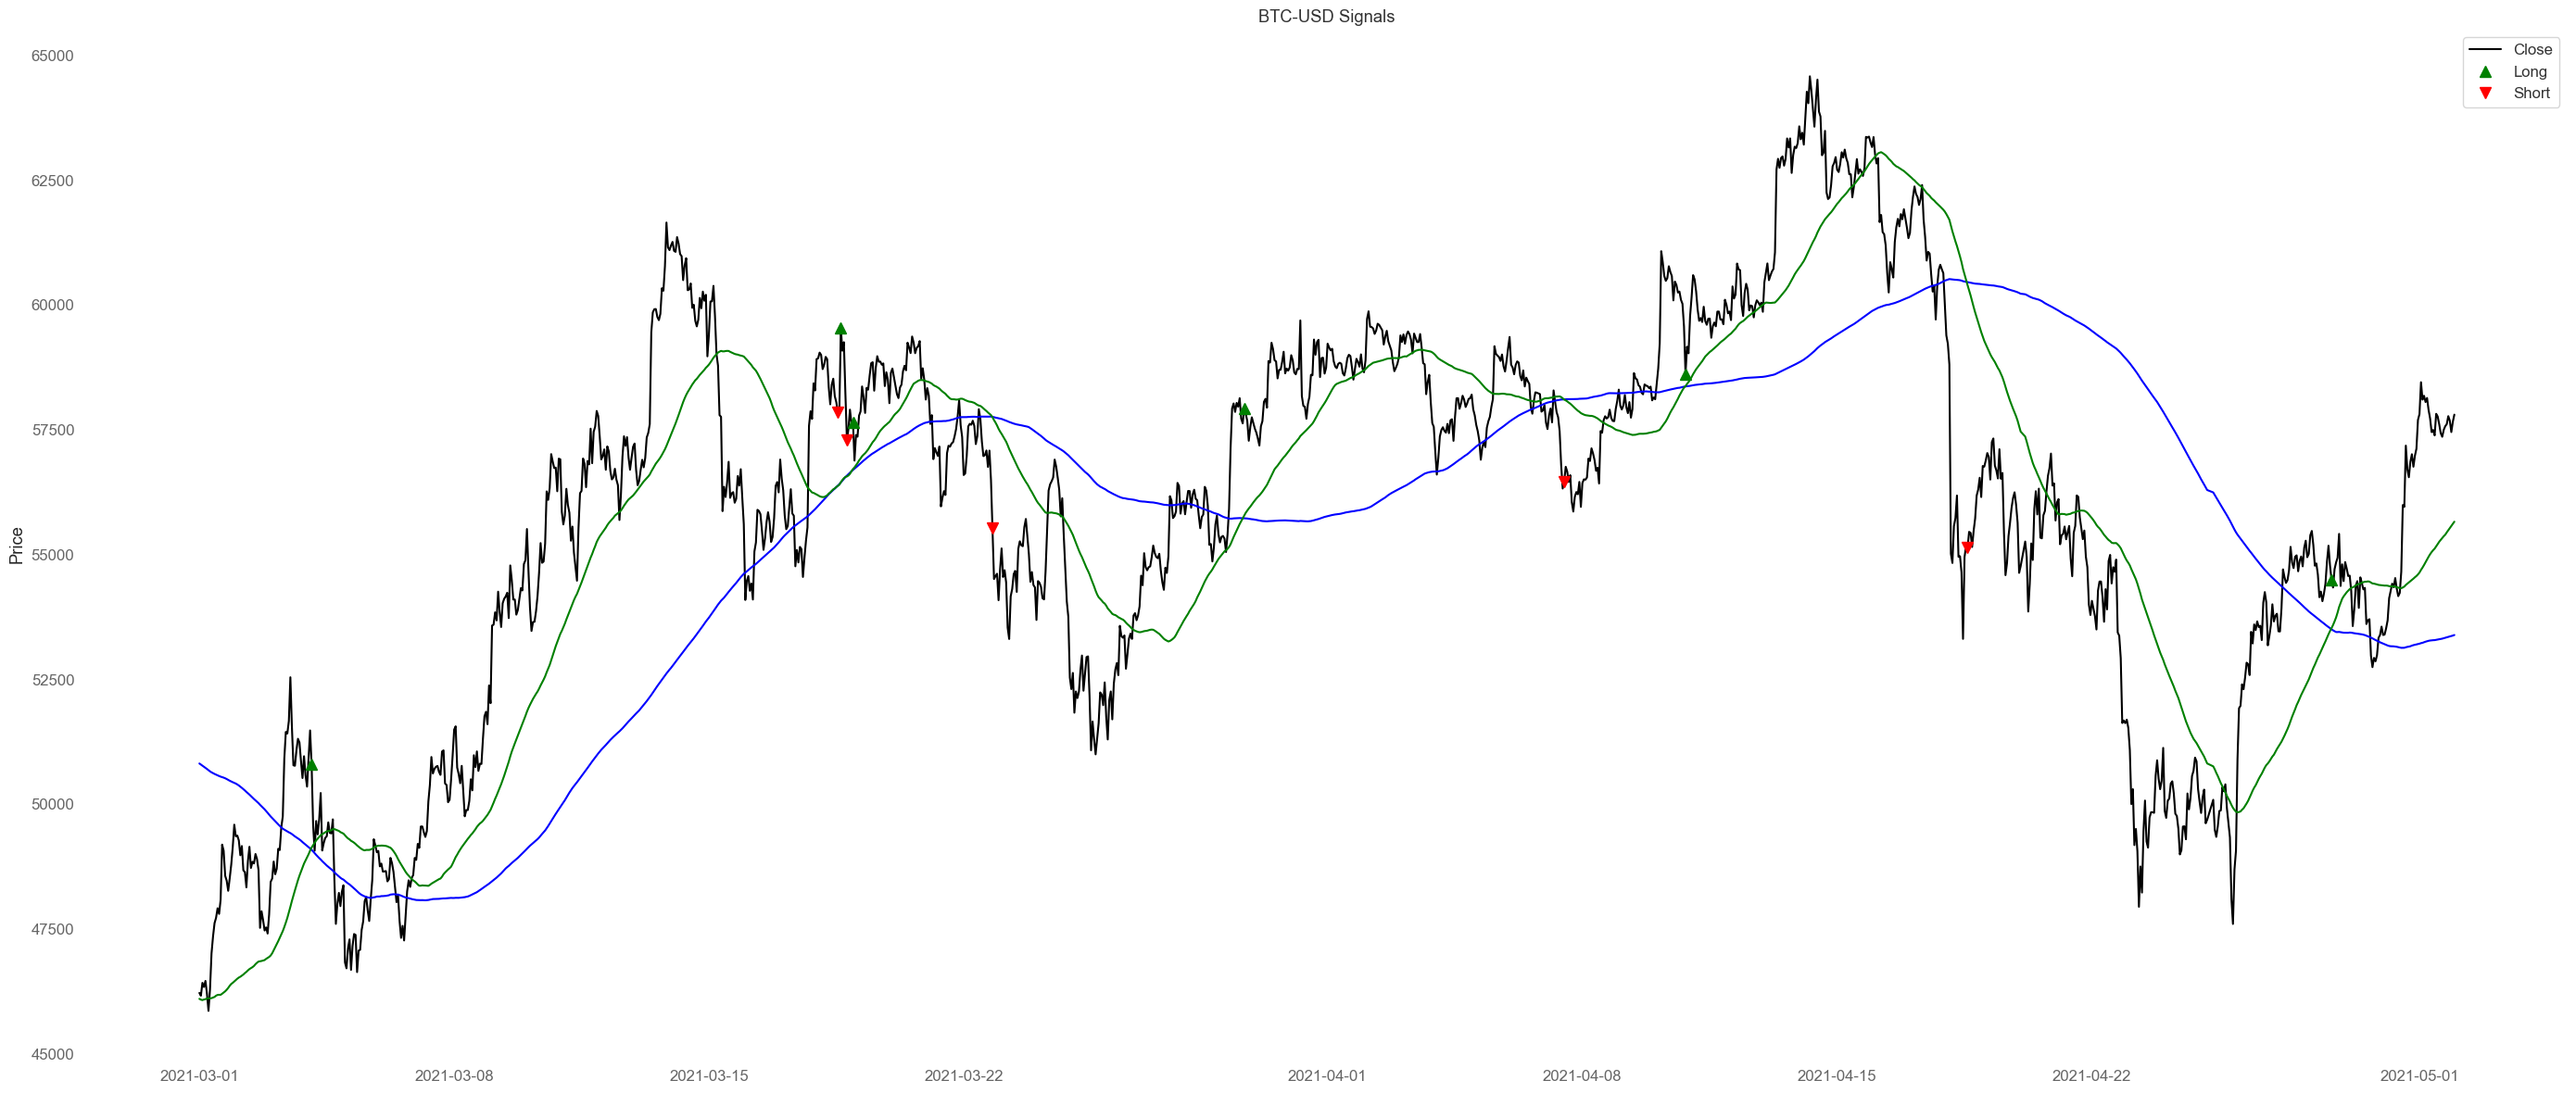

In [ ]:
#%%

plot_df = df["2021-03-01":"2021-05-01"]

fig, ax1 = plt.subplots(1, figsize=(28, 12), sharex=True)

ax1.plot(plot_df.index, plot_df['Close'], label='Close', color='black')
ax1.plot(plot_df['MASLOW'], color='blue' )
ax1.plot(plot_df['MAFAST'], color='green')
ax1.plot(plot_df[plot_df['Signal'] ==  1].index, plot_df[plot_df['Signal'] ==  1]['Close'], '^', markersize=8, color='green', label='Long' )
ax1.plot(plot_df[plot_df['Signal'] == -1].index, plot_df[plot_df['Signal'] == -1]['Close'], 'v', markersize=8, color='red'  , label='Short')
ax1.set_ylabel('Price')
ax1.set_title('BTC-USD Signals')
ax1.legend()
ax1.grid()

plt.tight_layout()
plt.show()

In [ ]:
#%%

# Saving signals extracted on higher timeframe to lower granularity timeframe

df_eval = df_.copy(deep=True)

df_eval['Signal'] = 0

for idx, row in df[df['Signal']== 1].iterrows():
    if idx in df_eval.index:
        df_eval.loc[idx, 'Signal'] = 1

for idx, row in df[df['Signal']==-1].iterrows():
    if idx in df_eval.index:
        df_eval.loc[idx, 'Signal'] = -1

look_ahead_shift = 1
df_eval['Signal' ] = df_eval['Signal' ].shift(hours*60+look_ahead_shift)

df_eval.dropna(inplace=True)

In [ ]:
#%%

df_eval['Signal'].value_counts()

Signal
 0.0    3343191
-1.0        134
 1.0        133
Name: count, dtype: int64

In [ ]:
#%%

# Position tracking

position         = 0
entry_timestamp  = None
entry_price      = 0
exit_timestamp   = None
exit_price       = 0
position_history = []

for index, row in df_eval.iterrows():
    if row['Signal'] != position:
        # Exit position
        if position != 0:
            exit_timestamp = index
            exit_price     = row['Close']
            pct_change     = (exit_price - entry_price) / entry_price
            position_history.append((entry_timestamp, exit_timestamp, entry_price, exit_price, pct_change, position))

        # Enter new position
        if row['Signal'] == 1:
            entry_timestamp = index
            entry_price     = row['Close']

        elif row['Signal'] == -1:
            entry_timestamp = index
            entry_price     = row['Close']

        position = row['Signal']

position_df = pd.DataFrame(position_history, columns=['Entry Time', 'Exit Time', 'Entry Price', 'Exit Price', 'Pct Change', 'Position'])

position_df

,Entry Time,Exit Time,Entry Price,Exit Price,Pct Change,Position
0,2017-09-04 22:01:00,2017-09-04 22:02:00,4258.40,4258.35,-0.000012,-1.0
1,2017-09-08 14:01:00,2017-09-08 14:02:00,4368.18,4352.69,-0.003546,1.0
2,2017-09-09 06:01:00,2017-09-09 06:02:00,4384.16,4367.41,-0.003821,-1.0
3,2017-09-20 09:01:00,2017-09-20 09:02:00,3944.79,3944.76,-0.000008,1.0
4,2017-09-23 07:01:00,2017-09-23 07:02:00,3696.00,3688.62,-0.001997,-1.0
...,...,...,...,...,...,...
262,2023-11-18 21:01:00,2023-11-18 21:02:00,36579.70,36597.39,0.000484,-1.0
263,2023-11-20 17:01:00,2023-11-20 17:02:00,37230.04,37204.99,-0.000673,1.0
264,2023-12-12 23:01:00,2023-12-12 23:02:00,41247.23,41247.23,0.000000,-1.0
265,2023-12-20 17:01:00,2023-12-20 17:02:00,43710.11,43755.60,0.001041,1.0


<Axes: >

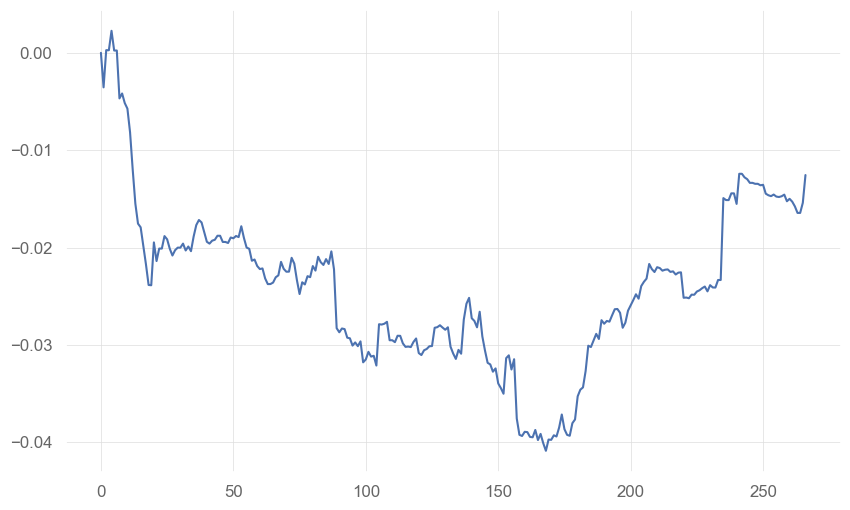

In [ ]:
#%%

position_df['StrategyReturn'] = position_df['Pct Change'] * position_df['Position']
position_df['StrategyCumsum'] = position_df['StrategyReturn'].cumsum()

# Naive cumulative sum
position_df['StrategyCumsum'].plot()

In [ ]:
#%%

# Cost adjustment
position_df['LogReturn'] = (1+position_df['StrategyReturn']).apply(np.log)

taker_fee_pct        = 0.05  # Binance taker fee is 0.05%
transaction_cost_log = np.log(1-taker_fee_pct/100.0)
position_df['AdjustedLogReturn'] = position_df['LogReturn'] + transaction_cost_log

position_df['CumRet'            ] = 1+position_df['StrategyReturn'].cumsum()
position_df['CostAdjustedCumRet'] = position_df['AdjustedLogReturn'].cumsum().apply(np.exp)

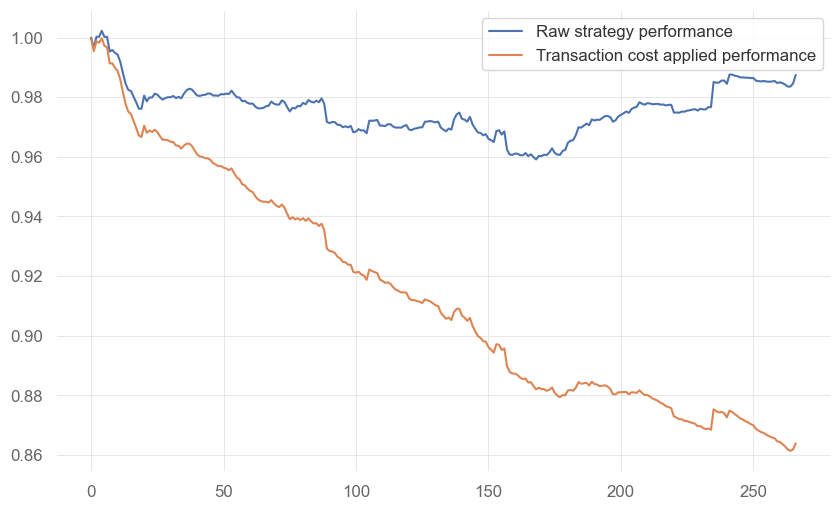

In [ ]:
#%%

position_df[['CumRet', 'CostAdjustedCumRet']].plot()
plt.legend(['Raw strategy performance', 'Transaction cost applied performance'])

<Axes: >

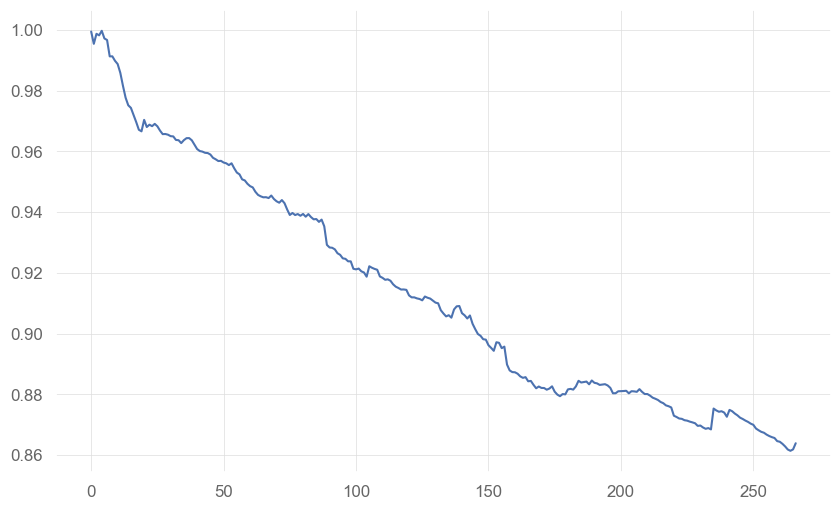

In [ ]:
#%%

position_df['CostAdjustedCumRet'].plot()

In [ ]:
#%%

position_df

,Entry Time,Exit Time,Entry Price,Exit Price,Pct Change,Position,StrategyReturn,StrategyCumsum,LogReturn,AdjustedLogReturn,CumRet,CostAdjustedCumRet
0,2017-09-04 22:01:00,2017-09-04 22:02:00,4258.40,4258.35,-0.000012,-1.0,0.000012,0.000012,0.000012,-0.000488,1.000012,0.999512
1,2017-09-08 14:01:00,2017-09-08 14:02:00,4368.18,4352.69,-0.003546,1.0,-0.003546,-0.003534,-0.003552,-0.004053,0.996466,0.995469
2,2017-09-09 06:01:00,2017-09-09 06:02:00,4384.16,4367.41,-0.003821,-1.0,0.003821,0.000286,0.003813,0.003313,1.000286,0.998773
3,2017-09-20 09:01:00,2017-09-20 09:02:00,3944.79,3944.76,-0.000008,1.0,-0.000008,0.000279,-0.000008,-0.000508,1.000279,0.998266
4,2017-09-23 07:01:00,2017-09-23 07:02:00,3696.00,3688.62,-0.001997,-1.0,0.001997,0.002275,0.001995,0.001495,1.002275,0.999759
...,...,...,...,...,...,...,...,...,...,...,...,...
262,2023-11-18 21:01:00,2023-11-18 21:02:00,36579.70,36597.39,0.000484,-1.0,-0.000484,-0.015762,-0.000484,-0.000984,0.984238,0.862830
263,2023-11-20 17:01:00,2023-11-20 17:02:00,37230.04,37204.99,-0.000673,1.0,-0.000673,-0.016435,-0.000673,-0.001173,0.983565,0.861818
264,2023-12-12 23:01:00,2023-12-12 23:02:00,41247.23,41247.23,0.000000,-1.0,-0.000000,-0.016435,0.000000,-0.000500,0.983565,0.861387
265,2023-12-20 17:01:00,2023-12-20 17:02:00,43710.11,43755.60,0.001041,1.0,0.001041,-0.015394,0.001040,0.000540,0.984606,0.861852
